In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
#import umap
import umap.umap_ as umap
import seaborn as sns
import scipy.stats as sts
from scipy.interpolate import griddata
import ipywidgets as widgets
from IPython.display import display
import io
import torch
import torch.nn as nn
import torch.optim as optim
import pickle as pkl
import torch
from helpers import *

### CONSTANTS

In [2]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip", "b0", "nel", "ptot", "pdiv", "q95", "betan", "kappa", "deltaavg", "deltaupp",
                  "deltalow", "gapin", "gapout", "zmag", "rmag", "rmin", "lpar_ot", "zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
precomputed_dir = 'precomputed_data/'

In [3]:
parquet_filename = '/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/tokamak-unsupervised/QCEH_data/TCV_DATAno78604.parquet'

In [4]:
def preprocess(filename):
    df = pd.read_parquet(filename)
    X = df[MACHINE_INPUTS]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    return df, X_standardized, MACHINE_INPUTS


def predict(X):
    with open(f"{precomputed_dir}model-19-64-.pkl", 'rb') as f:
        model = pkl.load(f)
    outputs = model(X)
    y_predicted = torch.argmax(outputs, dim=1)
    y_predicted = pd.Series(y_predicted + 1)
    return y_predicted


def show(X, y):
    X_pca = perform_pca(X)
    draw_reduced_space(X_pca[:, :3], y, n_components=3, legend_labels=None, legend_title="LHD Predicted Label", title='3D display of the given shot PCA with predicted labels.')
    draw_reduced_space(X_pca[:, :2], y, n_components=2, legend_labels=None, legend_title="LHD Predicted Label", title='2D display of the given shot PCA with predicted labels.')
    
def save(df, y):
    y = pd.Series(y)
    y.name = "LHD Predicted Label"
    dataframe = pd.concat([df, y], axis=1)
    dataframe.to_csv('prediction.csv', index=False)
    print('file is saved !')


In [5]:
def run(filename):
    df, X, column_names = preprocess(filename)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y = predict(X_tensor) 
    show(X, y)
    save(df, y)
    
    

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    
        # Unsqueeze to make hx and cx 2-D for unbatched input
        h0 = h0.squeeze(1)
        c0 = c0.squeeze(1)
    
        # Forward pass through LSTM layer
        out, _ = self.lstm(x.unsqueeze(1), (h0, c0))
    
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out



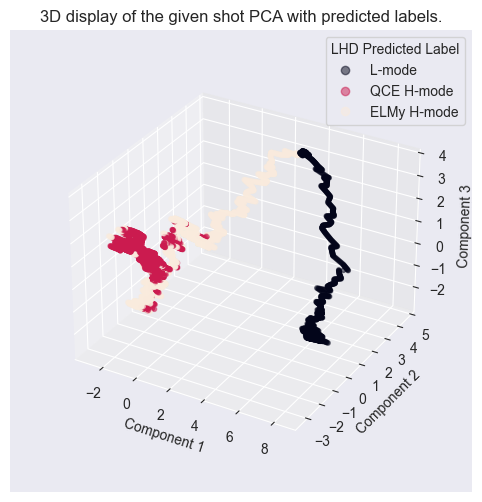

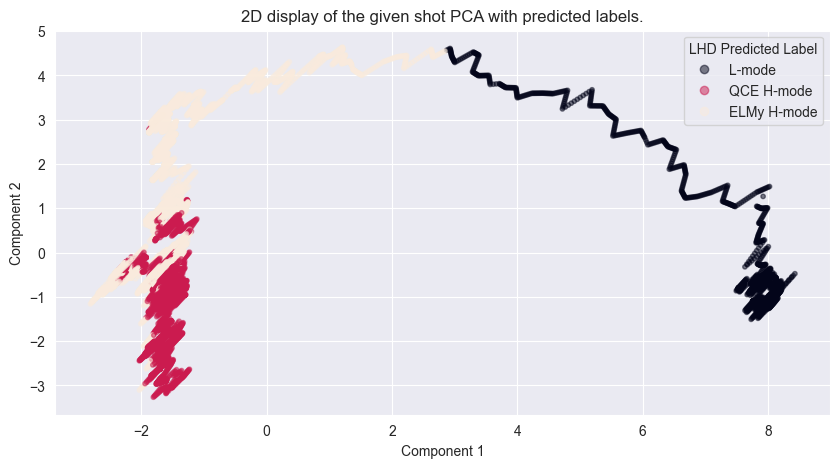

In [7]:
run(parquet_filename)